In [1]:
import pandas as pd
import numpy as np
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler

dataset = pd.read_csv('data.csv')

In [2]:
greece_data = dataset.loc[dataset['Entity'] == 'Greece', ['Date', 'Cases', 'Daily tests']].copy().reset_index(drop=True)

greece_data = greece_data.drop(greece_data.index[range(0, 25)])
greece_data = greece_data.drop(greece_data.index[range(364 - 25, 368 - 25)])
greece_data = greece_data.reset_index(drop=True)

greece_data['Date'] = pd.to_datetime(greece_data['Date'])
greece_data.sort_values('Date', inplace=True)

greece_data['Positivity'] = (greece_data['Cases'].diff() / greece_data['Daily tests']) * 100

greece_data

,Date,Cases,Daily tests,Positivity
0,2020-03-22,624.0,176.0,NaN
1,2020-03-23,695.0,638.0,11.128527
2,2020-03-24,743.0,427.0,11.241218
3,2020-03-25,821.0,1424.0,5.477528
4,2020-03-26,892.0,NaN,NaN
...,...,...,...,...
335,2021-02-20,178918.0,43310.0,3.287924
336,2021-02-21,179802.0,23139.0,3.820390
337,2021-02-22,180672.0,15610.0,5.573350
338,2021-02-23,182783.0,100543.0,2.099599


In [3]:
greece_data[['Positivity']] = greece_data[['Positivity']].apply(lambda x: x.fillna(method='ffill'))
greece_data[['Positivity']] = greece_data[['Positivity']].apply(lambda x: x.fillna(method='bfill'))
greece_data

,Date,Cases,Daily tests,Positivity
0,2020-03-22,624.0,176.0,11.128527
1,2020-03-23,695.0,638.0,11.128527
2,2020-03-24,743.0,427.0,11.241218
3,2020-03-25,821.0,1424.0,5.477528
4,2020-03-26,892.0,NaN,5.477528
...,...,...,...,...
335,2021-02-20,178918.0,43310.0,3.287924
336,2021-02-21,179802.0,23139.0,3.820390
337,2021-02-22,180672.0,15610.0,5.573350
338,2021-02-23,182783.0,100543.0,2.099599


In [4]:
greece_data[['Positivity']] = MinMaxScaler(feature_range=(0,1)).fit_transform(greece_data[['Positivity']])

In [5]:
X_train = []
y_train = []
X_test = []
y_test = []

datesInterval = 3
dateToPredictAfterToday = 3
splitDateIndex = greece_data.loc[greece_data['Date'] == '2021-01-01'].index[0]
endDateIndex = greece_data[['Positivity']].size - datesInterval

In [6]:
# Train sets
for date in range(datesInterval, splitDateIndex):
   X_train.append(greece_data['Positivity'][date - datesInterval : date]) 
   y_train.append(greece_data['Positivity'][date + dateToPredictAfterToday])

# Test sets 
for date in range(splitDateIndex, endDateIndex):
   X_test.append(greece_data['Positivity'][date - datesInterval : date]) 
   y_test.append(greece_data['Positivity'][date + dateToPredictAfterToday])

In [7]:
X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = np.array(X_test)
y_test = np.array(y_test)

X_train_rnn = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test_rnn = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

X_train_svm = np.reshape(X_train, (X_train.shape[0], -1))
X_test_svm = np.reshape(X_test, (X_test.shape[0], -1))

In [8]:
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(X_train_rnn.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

result = model.fit(X_train_rnn, y_train, epochs=100, batch_size=32)

Epoch 1/100
9/9 [==============================] - 12s 18ms/step - loss: 0.0560
Epoch 2/100
9/9 [==============================] - 0s 17ms/step - loss: 0.0336
Epoch 3/100
9/9 [==============================] - 0s 18ms/step - loss: 0.0276
Epoch 4/100
9/9 [==============================] - 0s 17ms/step - loss: 0.0181
Epoch 5/100
9/9 [==============================] - 0s 16ms/step - loss: 0.0167
Epoch 6/100
9/9 [==============================] - 0s 15ms/step - loss: 0.0158
Epoch 7/100
9/9 [==============================] - 0s 16ms/step - loss: 0.0158
Epoch 8/100
9/9 [==============================] - 0s 16ms/step - loss: 0.0159
Epoch 9/100
9/9 [==============================] - 0s 15ms/step - loss: 0.0153
Epoch 10/100
9/9 [==============================] - 0s 15ms/step - loss: 0.0151
Epoch 11/100
9/9 [==============================] - 0s 15ms/step - loss: 0.0150
Epoch 12/100
9/9 [==============================] - 0s 15ms/step - loss: 0.0148
Epoch 13/100
9/9 [==============================

In [9]:
model_svm = SVR(kernel='rbf')

model_svm.fit(X_train_svm, y_train)

SVR()

In [10]:
# Find the index corresponding to the '2021-01-01' date
start_index = greece_data.loc[greece_data['Date'] == '2021-01-01'].index[0]

# Create a DataFrame with 'Date' and 'y_test' values
result_df = pd.DataFrame({
    'Date': greece_data['Date'][start_index+3:],
    'y_test': y_test.flatten()
})

result_df.set_index('Date', inplace=True)

2/2 [==============================] - 2s 9ms/step


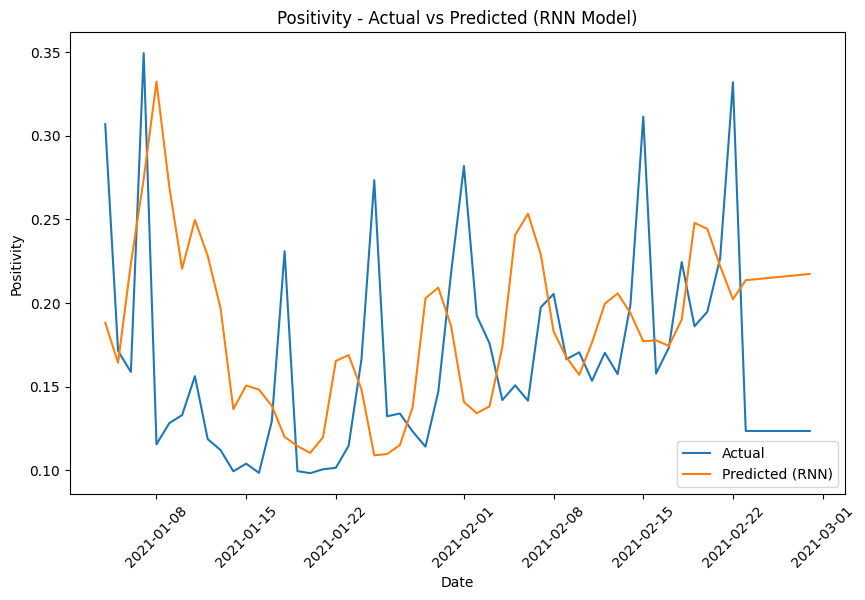

In [11]:
y_pred_rnn = model.predict(X_test_rnn)

# Plotting the predicted and actual values for RNN model
plt.figure(figsize=(10, 6))
plt.plot(result_df.index, result_df['y_test'], label='Actual')
plt.plot(result_df.index, y_pred_rnn, label='Predicted (RNN)')
plt.xlabel('Date')
plt.ylabel('Positivity')
plt.title('Positivity - Actual vs Predicted (RNN Model)')
plt.legend()
plt.xticks(rotation=45)
plt.show()

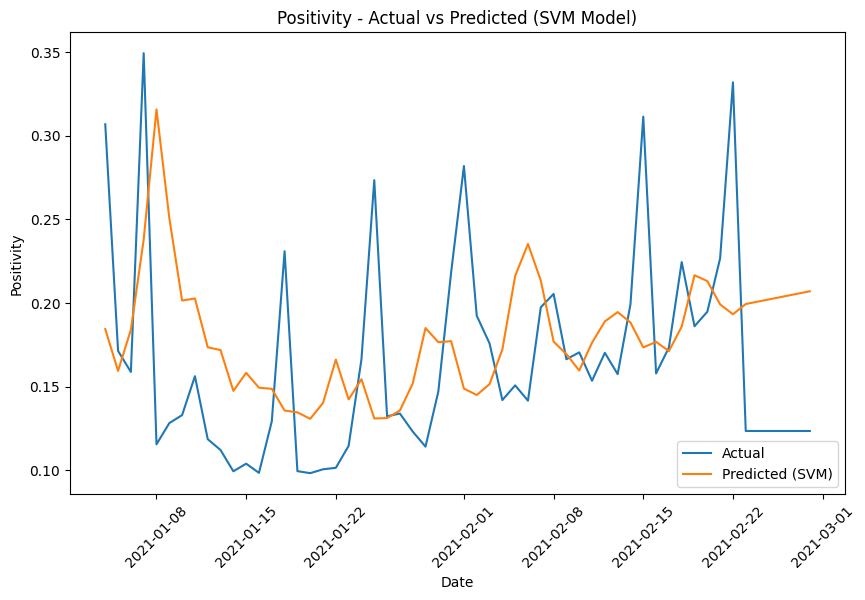

In [12]:
y_pred_svm = model_svm.predict(X_test_svm)

# Plotting the predicted and actual values for SVM model
plt.figure(figsize=(10, 6))
plt.plot(result_df.index, result_df['y_test'], label='Actual')
plt.plot(result_df.index, y_pred_svm, label='Predicted (SVM)')
plt.xlabel('Date')
plt.ylabel('Positivity')
plt.title('Positivity - Actual vs Predicted (SVM Model)')
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [13]:
# RNN Model Evaluation
rnn_predictions = model.predict(X_test_rnn)
rnn_mse = mean_squared_error(y_test, rnn_predictions)
rnn_mae = mean_absolute_error(y_test, rnn_predictions)
print("RNN Model Evaluation:")
print("MSE:", rnn_mse)
print("MAE:", rnn_mae)

# SVM Model Evaluation
svm_predictions = model_svm.predict(X_test_svm)
svm_mse = mean_squared_error(y_test, svm_predictions)
svm_mae = mean_absolute_error(y_test, svm_predictions)
print("SVM Model Evaluation:")
print("MSE:", svm_mse)
print("MAE:", svm_mae)

2/2 [==============================] - 0s 9ms/step
RNN Model Evaluation:
MSE: 0.0058641880466632984
MAE: 0.05963154541811519
SVM Model Evaluation:
MSE: 0.004699122803536821
MAE: 0.05251808952660974


Βασιζόμενοι μόνο σε αυτές τις μετρικές παρατηρούμε ότι το SVM είναι ελάχιστα καλύτερος παλινδρομητής σε σχέση με το RNN αφού έχει μικρότερες MAE και MSE τιμές.